#1. Import Libraries dan Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop

from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ihsan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ihsan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
byte_sequence = b'\x80\x81...'
decoded_string = byte_sequence.decode('utf-8', errors='ignore')
df=pd.read_csv("C:/Users/ihsan/Downloads/spam.csv",encoding=('latin-1'))

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


#2. Pra proses Data
* Data Cleaning
* Lower case
* Tokenization
* Removing special characters
* Removing stop words and punctuation
* Stemming


In [4]:
print(df.shape)
print('==========')
print(df.info())

(5572, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None


## 2.1 Data cleaning
Tahap ini bertujuan menghapus kolom, duplikasi, dan null yang ada

In [5]:
# Hapus kolom
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis='columns',inplace=True)
# Ubah nama kolom
df.rename(columns={'v1':'target','v2':'text'},inplace=True)
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
print("shape sebelum hapus duplikat", df.shape)
df = df.drop_duplicates(keep='first')
print("shape setelah hapus duplikat",df.shape)

shape sebelum hapus duplikat (5572, 2)
shape setelah hapus duplikat (5169, 2)


Ubah kelas ham jadi 0 dan spam jadi 1

In [7]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# cek apakah ada data null
print(f'{df.isnull().sum()}')

target    0
text      0
dtype: int64


##2.2 Visualisasi data spam dan ham after cleaning

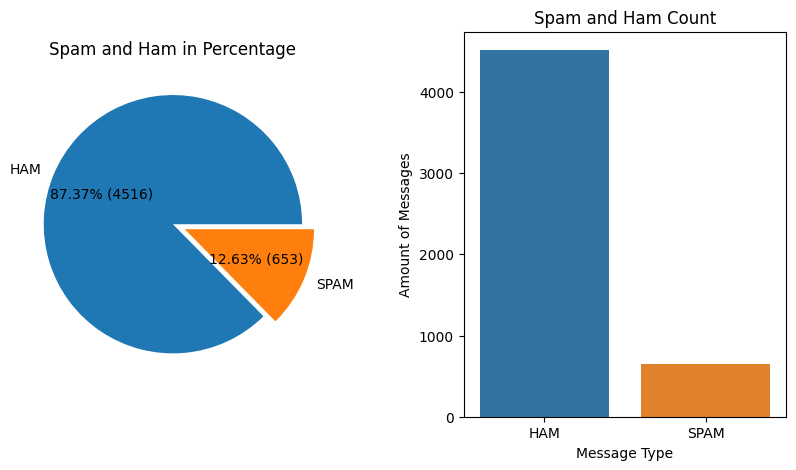

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the counts of each class
counts = df['target'].value_counts()
# Create the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Pie chart
axs[0].pie(df['target'].value_counts(), explode=[0, 0.1], labels=['HAM', 'SPAM'], autopct=lambda p: f'{p:.2f}% ({int(p * sum(counts) / 100)})')
axs[0].set_title("Spam and Ham in Percentage")

# Bar plot
sns.barplot(x=['HAM', 'SPAM'], y=df['target'].value_counts(), ax=axs[1])
axs[1].set_title("Spam and Ham Count")
axs[1].set_xlabel("Message Type")
axs[1].set_ylabel("Amount of Messages")

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Display the figure
plt.show()


In [10]:
# df['num_characters'] = df['text'].apply(len)
# df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
# df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
# df.head()

# df.drop(['num_characters','num_words','num_sentences'],axis='columns',inplace=True)
# df.head()

##2.3 Transformasi Text Menggunakan NTLK

In [11]:
def transform(text):
    # Remove whitespace
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)

    # Remove special characters
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern, '', text)

    # LOWERCASE
    tokens = word_tokenize(text.lower())

    # Remove non-alphanumeric tokens
    tokens = [t for t in tokens if t.isalnum()]

    # Remove stopwords and punctuation
    stopwords_set = set(stopwords.words('english')+ ['u', 'im'])
    punctuation_set = set(string.punctuation)
    tokens = [t for t in tokens if t not in stopwords_set and t not in punctuation_set]

    # Stem the remaining tokens using PorterStemmer
    ps = PorterStemmer()
    tokens = [ps.stem(t) for t in tokens]

    # Join the tokens back into a string and return it
    return tokens


In [12]:
print(f"{df['text'][10]}\n{transform(df['text'][10])}")

I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
['gon', 'na', 'home', 'soon', 'dont', 'want', 'talk', 'stuff', 'anymor', 'tonight', 'k', 'ive', 'cri', 'enough', 'today']


In [13]:
df['text'] = df['text'].apply(transform)

In [14]:
df['text'] = df['text'].astype(str)

In [15]:
df.head()

,target,text
0,0,"['go', 'jurong', 'point', 'crazi', 'avail', 'b..."
1,0,"['ok', 'lar', 'joke', 'wif', 'oni']"
2,1,"['free', 'entri', '2', 'wkli', 'comp', 'win', ..."
3,0,"['dun', 'say', 'earli', 'hor', 'c', 'alreadi',..."
4,0,"['nah', 'dont', 'think', 'goe', 'usf', 'live',..."


In [16]:
print(df['text'])

0       ['go', 'jurong', 'point', 'crazi', 'avail', 'b...
1                     ['ok', 'lar', 'joke', 'wif', 'oni']
2       ['free', 'entri', '2', 'wkli', 'comp', 'win', ...
3       ['dun', 'say', 'earli', 'hor', 'c', 'alreadi',...
4       ['nah', 'dont', 'think', 'goe', 'usf', 'live',...
                              ...                        
5567    ['2nd', 'time', 'tri', '2', 'contact', '750', ...
5568                ['b', 'go', 'esplanad', 'fr', 'home']
5569                 ['piti', 'mood', 'soani', 'suggest']
5570    ['guy', 'bitch', 'act', 'like', 'id', 'interes...
5571                             ['rofl', 'true', 'name']
Name: text, Length: 5169, dtype: object


#3. EDA

In [17]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

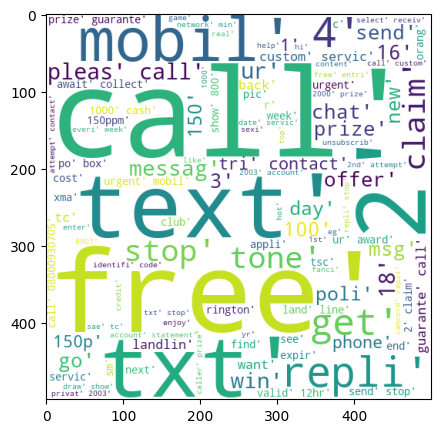

In [18]:
spam_wc = wc.generate(df[df['target'] == 1]['text'].str.cat(sep=" "))
plt.figure(figsize=(5,5))
plt.imshow(spam_wc)

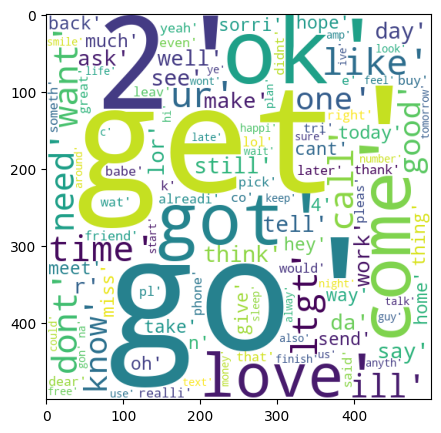

In [19]:
ham_wc = wc.generate(df[df['target'] == 0]['text'].str.cat(sep=" "))
plt.figure(figsize=(5,5))
plt.imshow(ham_wc)

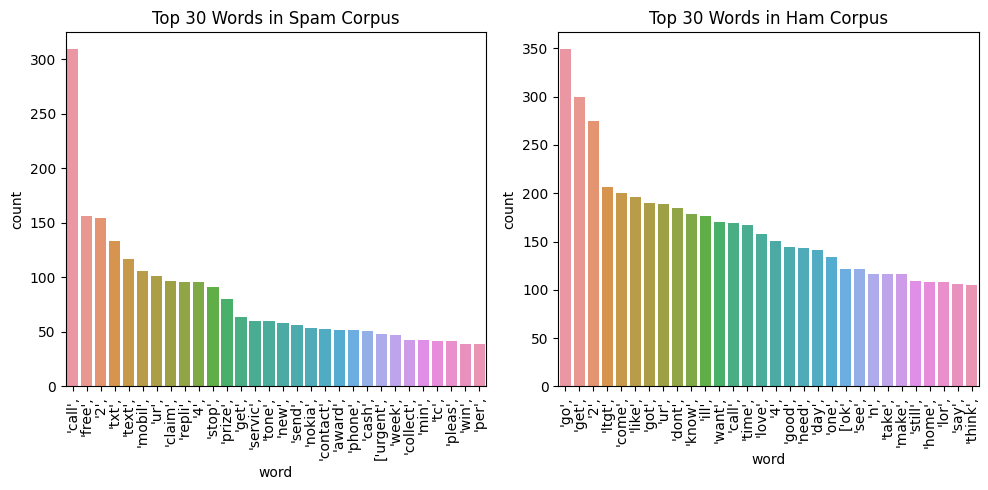

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Group by target and apply Counter to calculate word frequencies
word_freq_spam = Counter(df[df['target'] == 1]['text'].str.split().sum()).most_common(30)
word_freq_ham = Counter(df[df['target'] == 0]['text'].str.split().sum()).most_common(30)

# Create dataframes for plotting
word_freq_df_spam = pd.DataFrame(word_freq_spam, columns=['word', 'count'])
word_freq_df_ham = pd.DataFrame(word_freq_ham, columns=['word', 'count'])

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot for spam corpus
sns.barplot(data=word_freq_df_spam, x='word', y='count', ax=ax1)
ax1.set_title('Top 30 Words in Spam Corpus')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation='vertical')

# Plot for ham corpus
sns.barplot(data=word_freq_df_ham, x='word', y='count', ax=ax2)
ax2.set_title('Top 30 Words in Ham Corpus')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation='vertical')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

#4. Imbalanced Data

In [21]:
import pandas as pd

class_distribution = df['target'].value_counts()

print("Class distribution:")
print(class_distribution)

Class distribution:
target
0    4516
1     653
Name: count, dtype: int64


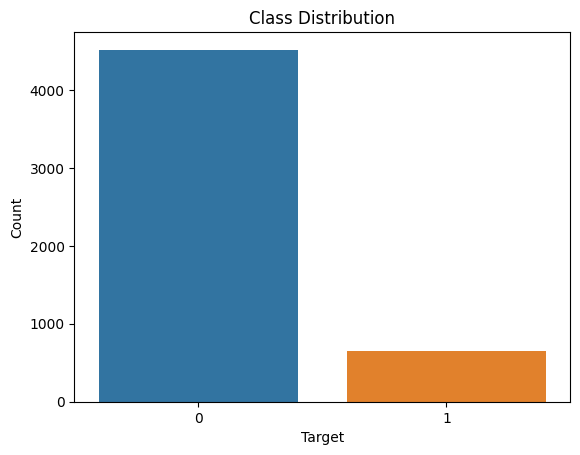

In [22]:
sns.countplot(data=df, x='target')
plt.title("Class Distribution")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

In [23]:
# df2 = df[['target', 'transformed_text']]
# df2.head(10)

**OVERSAMPLING DATA**

In [24]:
from imblearn.over_sampling import RandomOverSampler

# Separate features (X) and target variable (y)
x = df.drop('target', axis=1)  # Features excluding the target column
y = df['target']  # Target variable

# Create an instance of RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy = 'minority', random_state=42)

x_resampled, y_resampled = oversampler.fit_resample(x, y)

print("Class distribution after oversampling:")
print(y_resampled.value_counts())

Class distribution after oversampling:
target
0    4516
1    4516
Name: count, dtype: int64


**UNDERSAMPLING DATA**

In [25]:
# from imblearn.under_sampling import RandomUnderSampler

# # Separate features (X) and target variable (y)
# x = df.drop('target', axis=1)  # Features excluding the target column
# y = df['target']  # Target variable

# # Create an instance of RandomUnderSampler
# undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)

# x_resampled, y_resampled = undersampler.fit_resample(x, y)

# print("Class distribution after undersampling:")
# print(y_resampled.value_counts())


In [26]:
# x_resampled = np.array(x_resampled)
x_resampled

,text
0,"['go', 'jurong', 'point', 'crazi', 'avail', 'b..."
1,"['ok', 'lar', 'joke', 'wif', 'oni']"
2,"['free', 'entri', '2', 'wkli', 'comp', 'win', ..."
3,"['dun', 'say', 'earli', 'hor', 'c', 'alreadi',..."
4,"['nah', 'dont', 'think', 'goe', 'usf', 'live',..."
...,...
9027,"['guarante', '1000', 'cash', '2000', 'prize', ..."
9028,"['1000', 'flirt', 'txt', 'girl', 'bloke', 'ur'..."
9029,"['80488', '500', 'free', 'text', 'messag', 'va..."
9030,"['wwwapplausestorecom', 'monthlysubscription50..."


In [27]:
print(y_resampled[:5])

0    0
1    0
2    1
3    0
4    0
Name: target, dtype: int32


In [28]:
# Combine X_resampled_df and y_resampled_df into a single DataFrame
df_os = pd.concat([y_resampled, x_resampled], axis=1)
# print(df2_os.shape)
# df2_os.drop(['text'],axis='columns',inplace=True)
df_os.head()

,target,text
0,0,"['go', 'jurong', 'point', 'crazi', 'avail', 'b..."
1,0,"['ok', 'lar', 'joke', 'wif', 'oni']"
2,1,"['free', 'entri', '2', 'wkli', 'comp', 'win', ..."
3,0,"['dun', 'say', 'earli', 'hor', 'c', 'alreadi',..."
4,0,"['nah', 'dont', 'think', 'goe', 'usf', 'live',..."


In [29]:
print(x_resampled.shape)  # Shape of X_resampled
print(y_resampled.shape)  # Shape of y_resampled

(9032, 1)
(9032,)


In [30]:
# Assuming 'df' is your DataFrame containing the target column
class_distribution = df_os['target'].value_counts()

print("Class distribution:")
print(class_distribution)

Class distribution:
target
0    4516
1    4516
Name: count, dtype: int64


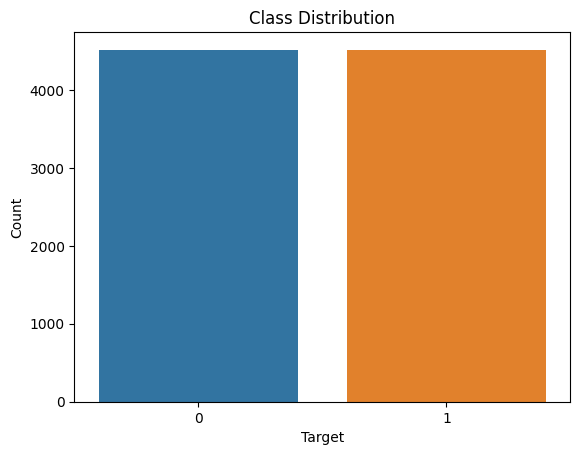

In [31]:
sns.countplot(data=df_os, x='target')
plt.title("Class Distribution")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

In [32]:
df_os

,target,text
0,0,"['go', 'jurong', 'point', 'crazi', 'avail', 'b..."
1,0,"['ok', 'lar', 'joke', 'wif', 'oni']"
2,1,"['free', 'entri', '2', 'wkli', 'comp', 'win', ..."
3,0,"['dun', 'say', 'earli', 'hor', 'c', 'alreadi',..."
4,0,"['nah', 'dont', 'think', 'goe', 'usf', 'live',..."
...,...,...
9027,1,"['guarante', '1000', 'cash', '2000', 'prize', ..."
9028,1,"['1000', 'flirt', 'txt', 'girl', 'bloke', 'ur'..."
9029,1,"['80488', '500', 'free', 'text', 'messag', 'va..."
9030,1,"['wwwapplausestorecom', 'monthlysubscription50..."


In [33]:
# from nltk.tokenize import word_tokenize
# df2_os['transformed_text'] = df2_os['transformed_text'].apply(word_tokenize)
# print(df2_os['transformed_text'])

#5. Building Model

In [34]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

labels=df_os["target"]
encoded_data = label_encoder.fit_transform(labels)
labels=encoded_data
encoded_data

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [35]:
labels.shape

(9032,)

In [36]:
text = df_os['text']
text.shape

(9032,)

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.7, random_state=42)

In [38]:
X_train

7507    ['mobil', '10', 'mth', 'updat', 'latest', 'ora...
6688    ['urgent', 'mobil', 'award', '2000', 'bonu', '...
359     ['updatenow', 'xma', 'offer', 'latest', 'motor...
3839    ['need', 'stop', 'go', 'bed', 'make', 'fuck', ...
6607    ['urgent', 'tri', 'contact', 'last', 'weekend'...
                              ...                        
5734    ['free', 'rington', 'text', 'first', '87131', ...
5191    ['sexi', 'singl', 'wait', 'text', 'age', 'foll...
5390    ['sparkl', 'shop', 'break', '45', 'per', 'pers...
860     ['secret', 'admir', 'look', '2', 'make', 'cont...
7270    ['1st', 'wk', 'free', 'gr8', 'tone', 'str8', '...
Name: text, Length: 2709, dtype: object

In [39]:
y_train

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [40]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 2
embedding_layer = Embedding(vocab_size, embedding_dim)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

max_length = 2
train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [41]:
y_train

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [42]:
# Buat model
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(units=16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.1))

# model.add(Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
# model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2, 2)              9638      
                                                                 
 conv1d (Conv1D)             (None, 2, 64)             192       
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                        

In [43]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='accuracy', patience=1, restore_best_weights=True)

In [45]:
history = model.fit(train_sequences,
                    y_train,
                    validation_data=(test_sequences, y_test),
                    epochs=30,
                    batch_size=256,
                    )

loss, accuracy = model.evaluate(test_sequences, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/30
11/11 [==============================] - 1s 24ms/step - loss: 1.3392 - accuracy: 0.5168 - val_loss: 1.2956 - val_accuracy: 0.5679
Epoch 2/30
11/11 [==============================] - 0s 9ms/step - loss: 1.2638 - accuracy: 0.5611 - val_loss: 1.2238 - val_accuracy: 0.6239
Epoch 3/30
11/11 [==============================] - 0s 9ms/step - loss: 1.1943 - accuracy: 0.6578 - val_loss: 1.1586 - val_accuracy: 0.5902
Epoch 4/30
11/11 [==============================] - 0s 9ms/step - loss: 1.1319 - accuracy: 0.6419 - val_loss: 1.1003 - val_accuracy: 0.7016
Epoch 5/30
11/11 [==============================] - 0s 9ms/step - loss: 1.0758 - accuracy: 0.7634 - val_loss: 1.0479 - val_accuracy: 0.7874
Epoch 6/30
11/11 [==============================] - 0s 9ms/step - loss: 1.0254 - accuracy: 0.8317 - val_loss: 1.0013 - val_accuracy: 0.8245
Epoch 7/30
11/11 [==============================] - 0s 9ms/step - loss: 0.9801 - accuracy: 0.8357 - val_loss: 0.9587 - val_accuracy: 0.8392
Epoch 8/30
11/11 [=

In [46]:
# Mendefinisikan data uji (X_test dan y_test)

# Menggunakan model yang sudah dilatih sebelumnya
loss, accuracy = model.evaluate(test_sequences, y_test, verbose=1)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


198/198 [==============================] - 0s 1ms/step - loss: 0.3097 - accuracy: 0.9458
Test Loss: 0.30966758728027344
Test Accuracy: 0.9457535743713379


<function matplotlib.pyplot.show(close=None, block=None)>

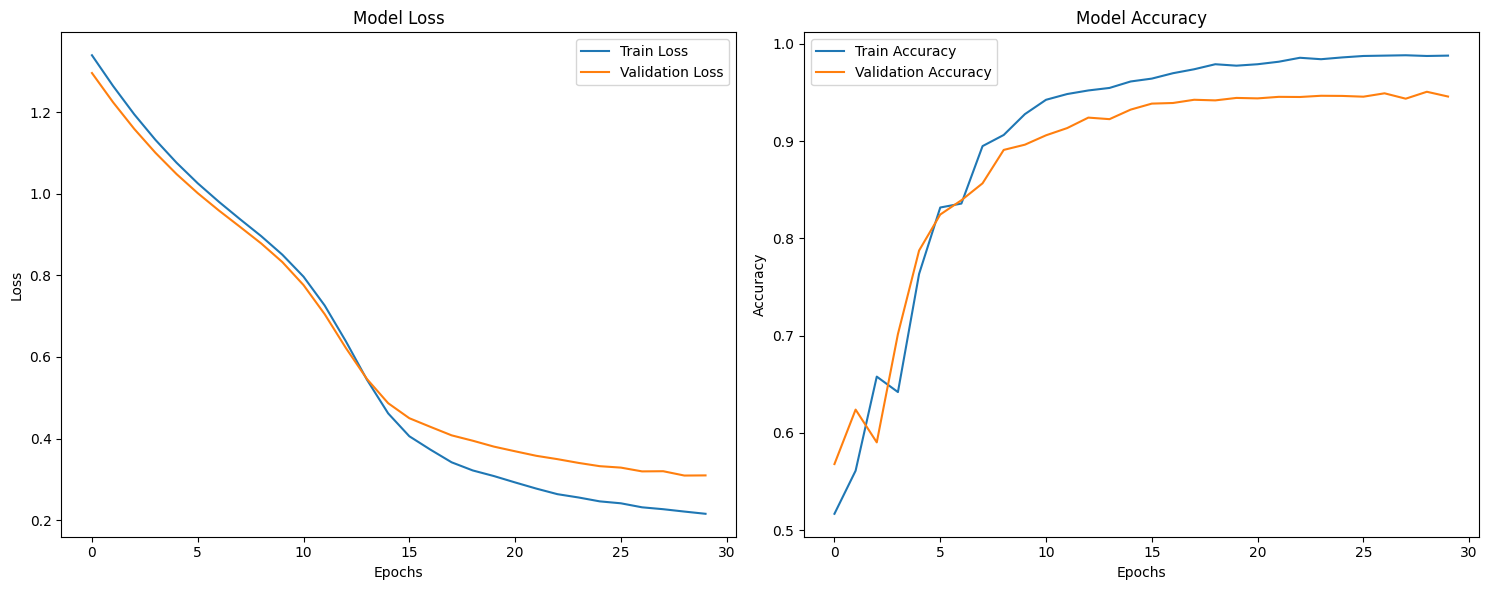

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Plot model loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot model accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the combined plot
plt.show

In [248]:
model.evaluate(test_sequences, y_test)

198/198 [==============================] - 0s 966us/step - loss: 0.2662 - accuracy: 0.9548


[0.266196072101593, 0.9547683000564575]

In [249]:
X_test_array = np.array(test_sequences)
y_preds = model.predict(X_test_array)
y_preds

198/198 [==============================] - 0s 675us/step


array([[0.00796904],
       [0.07455966],
       [0.99169636],
       ...,
       [0.0121243 ],
       [0.00644611],
       [0.9741557 ]], dtype=float32)

In [250]:
print(X_test_array.shape)

(6323, 2)


In [251]:
X_test

2373                             ['mm', 'way', 'railway']
8209    ['urgent', 'mobil', 'award', '1500', 'bonu', '...
8993    ['hi', 'sexychat', 'girl', 'wait', 'text', 'te...
5239    ['summer', 'final', 'fanci', 'chat', 'flirt', ...
6013    ['2nd', 'attempt', 'contract', 'week', 'top', ...
                              ...                        
1827           ['probabl', 'earlier', 'station', 'think']
3632    ['free', 'msg', 'ringtonefrom', 'httptm', 'wid...
962                               ['yo', 'guess', 'drop']
2993    ['thank', 'better', 'work', 'caus', 'feel', 'u...
8732    ['free', 'rington', 'text', 'first', '87131', ...
Name: text, Length: 6323, dtype: object

In [252]:
X_test_array

array([[ 231, 2895],
       [  23,    1],
       [  10,   28],
       ...,
       [ 446,  624],
       [ 135,  874],
       [   4,   10]])

In [253]:
from sklearn.metrics import confusion_matrix

y_preds = (model.predict(X_test_array) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_preds)
print(cm)

198/198 [==============================] - 0s 694us/step
[[3015  153]
 [ 133 3022]]


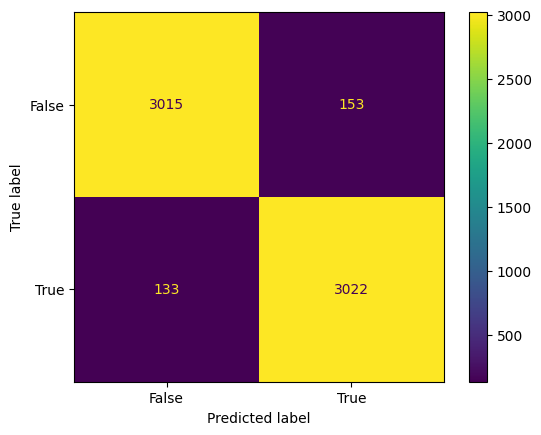

In [254]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


confusion_matrix = metrics.confusion_matrix(y_test, y_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

#5. LSTM MODEL

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(
#     train_padded_sentences,
#     target,
#     test_size=0.25
# )

NameError: ignored

In [ ]:
import re
import string
from tensorflow.keras.preprocessing.sequence import pad_sequences

def clean_text(text):
    # Mengubah teks menjadi lowercase
    text = text.lower()

    # Menghapus karakter yang tidak diperlukan
    text = re.sub(r'\d+', '', text)  # Menghapus angka
    text = text.translate(str.maketrans('', '', string.punctuation))  # Menghapus tanda baca

    # Tokenisasi teks menjadi kata-kata
    words = text.split()

    # Menggabungkan kata-kata menjadi teks kembali
    cleaned_text = ' '.join(words)

    # Menghapus whitespace berlebih
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)

    print(cleaned_text)

    return cleaned_text

# Tahap cleaning dan preprocessing input
def preprocess_input(input_text):
    cleaned_text = transform(input_text)
    preprocessed_text = tokenizer.texts_to_sequences([cleaned_text])
    preprocessed_text = pad_sequences(preprocessed_text, maxlen=max_length)
    return preprocessed_text

# Meminta input dari pengguna
input_text = input("Masukkan teks untuk diprediksi: ")

# Melakukan tahap cleaning dan preprocessing pada input
preprocessed_input = preprocess_input(input_text)


Masukkan teks untuk diprediksi: go jurong
go jurong


In [ ]:
def transform(text):
    # Remove whitespace
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)

    # Remove special characters
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern, '', text)

    # LOWERCASE
    tokens = word_tokenize(text.lower())

    # Remove non-alphanumeric tokens
    tokens = [t for t in tokens if t.isalnum()]

    # Remove stopwords and punctuation
    stopwords_set = set(stopwords.words('english')+ ['u', 'im'])
    punctuation_set = set(string.punctuation)
    tokens = [t for t in tokens if t not in stopwords_set and t not in punctuation_set]

    # Stem the remaining tokens using PorterStemmer
    ps = PorterStemmer()
    tokens = [ps.stem(t) for t in tokens]

    # Join the tokens back into a string and return it
    return tokens


In [ ]:
# Meminta input dari pengguna
input_text = input("Masukkan teks untuk diprediksi: ")

# Melakukan tahap cleaning dan preprocessing pada input
preprocessed_input = preprocess_input(input_text)

# Melakukan prediksi pada inputan pengguna
prediction = model.predict(preprocessed_input)[0][0]

prediction

KeyboardInterrupt: ignored

In [ ]:
def textProcess(sms):
    try:
        # brackets replacing by space
        sms = re.sub('[][)(]',' ',sms)

        # url removing
        sms = [word for word in sms.split() if not urlparse(word).scheme]
        sms = ' '.join(sms)

        # removing words starts from @
        sms = re.sub(r'\@\w+','',sms)

        # removing html tags
        sms = re.sub(re.compile("<.*?>"),'',sms)

        # getting only characters and numbers
        sms = re.sub('[^A-Za-z0-9]',' ',sms)

        # make all words into lowercase
        sms = sms.lower()

        # word tokennization
        tokens = word_tokenize(sms,language='english')

        # removing whitespaces
        sms = [word.strip() for word in tokens]

#         # removing word and number combinations or numbers
#         sms = [word for word in sms if not re.search('\d.',word)]

        # stopwords removing
        sms = [word for word in sms if word not in stop_words]

        # lemmatization
        sms = [lemmatizer.lemmatize(word) for word in sms]
        sms = ' '.join(sms)

        return sms
    except Exception as e:
        print("sms",sms)
        print("Error",e)
        return 0

def manager(sms):
    sms = textProcess(sms)
    # sms = tf_vec.transform([sms])
    result = model.predict(sms)
    return result

In [ ]:
sms1 = """100% of daily 1.50 GB data quota exhausted as on 26-May-23 00:31.
Jio Number : Daily high speed data quota will be restored on 26-May-23 01:04.
To know where you have consumed your data quota, click """

sms2 = """Hurry! Recharge Jio no.XXXXXXXXXX on PhonePe & get rewards upto Rs.500
each on first 3 recharges for self & family. Recharge with Rs.239 plan .T&CA.
Click https://phon.pe/jion1"""

In [ ]:
sms_lis = [sms1,sms2]

In [ ]:
for i,sms in enumerate(sms_lis):
    res = manager(sms)
    print("sms "+str(i+1),res)

In [ ]:
# Make predictions on the test data
# predictions = model.predict(X_test)

# Convert the predictions to binary values (0 or 1) based on a threshold
threshold = 0.5
# binary_predictions = (predictions > threshold).astype(int)

# Compare the predictions with the true labels (y_test)
accuracy = (binary_predictions == y_test.values.reshape(-1, 1)).mean()
print("Accuracy:", accuracy)

In [ ]:
import numpy as np

X_test_array = np.array(X_test)
y_preds = model.predict(X_test_array)

In [ ]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix(metrics.confusion_matrix(y_test, y_preds))

In [ ]:
y_test_reshaped = y_test.values.reshape(-1, 1)
predictions = model.predict(y_test_reshaped)